In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf



In [2]:
# anulo el uso de la GPU por falta de memoria
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# No GPU found

# tf.enable_eager_execution()
tf.VERSION

No GPU found


'1.13.1'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2

from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import keras.backend as K

from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train


DATA_PATH = "data"

Using TensorFlow backend.


In [4]:
import os
print(os.listdir("data"))

['processed_train_images', 'train.csv', 'train_images', 'test.csv', 'test_images', 'processed_test_images', 'sample_submission.csv']


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3407234163082605366
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7433479149977161742
physical_device_desc: "device: XLA_CPU device"
]


# 1. Introduction. Explore first, train later.

Hi everyone! As *Aravind Eye Hospital* is one of my favorite organization in the world; they take care of poor people's eyes for free with an impressive sustainable business model.  I will try my best to contribute something to our community. One intuitive way to improve the performance of our model is to simply improve the quality of input images. In this kernel, I will share two ideas which I hope may be useful to some of you : 

- **Decolorize images** : here as we will see, images come with many different lighting conditions, some images are quite dark and difficult to visualize. We can try to convert the image to gray scale, and visualize better. Alternatively, we can try the method of [Ben Graham (last competition's winner)](https://github.com/btgraham/SparseConvNet/tree/kaggle_Diabetic_Retinopathy_competition)
- **Cropping uninformative area** : everyone know this :) Here, I just find the codes from internet and choose the best one for you :)

We are going to apply both techniques to both the official data, and the past competition data (shout out @tanlikesmath for creating this dataset! https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized . In the updated version, I also try @donkeys' dataset https://www.kaggle.com/donkeys/retinopathy-train-2015 , which is .png which may be have higer image quality than .jpeg format)

If I found more useful tricks, I will update the notebook, or if you have more useful tricks and would love to share, please let me know!

I use some parts of codes from @mathormad and @artgor kernels. Thanks both of you!

Now let us start by loading the train/test dataframes. The `train_test_split` here is in fact not necessary. But when I first fork the kernel from @mathormad, I found some interesting examples using this split and the current `SEED`, so I continue to use them here.

In [6]:
df_train = pd.read_csv(DATA_PATH + '/train.csv')
df_test = pd.read_csv(DATA_PATH + '/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)


(3112,) (3112,) (550,) (550,)


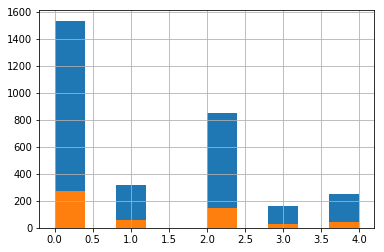

In [7]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

## 1.1 Simple picture to explain Diabetic Retinopathy

How do we know that a patient have diabetic retinopahy? There are 5 things to spot on. Image credit https://www.eyeops.com/
![credit : https://www.eyeops.com/](https://sa1s3optim.patientpop.com/assets/images/provider/photos/1947516.jpeg)

From quick investigations of the data (see various pictures below), I found that *Hemorrphages, Hard Exudates and Cotton Wool spots* are quite easily observed. However, I still could not find examples of *Aneurysm* or *Abnormal Growth of Blood Vessels* from our data yet. Perhaps the latter two cases are important if we want to catch up human benchmnark using our model.

## Process TFRecord

In [8]:
# Aquí transcribimos las imágenes a un fichero tipo TFRECORD de tamaño
width = 400
height = 500

size = (width,height)
# the TFRecord file
# imagesXXX_XXX file has three elements in feature definition
# images2XXX_XXX has two elements in feature definition
TFRecord_filename = '/mnt/DATA-SSD/DataSandbox/images2{}_{}.tfrecords'.format(width,height)

raw_image_dataset = tf.data.TFRecordDataset(TFRecord_filename)
'''
image_feature_description = {
    'img': tf.io.FixedLenFeature([200000], tf.float32),
    'label': tf.io.FixedLenFeature([5], tf.float32),
    # https://stackoverflow.com/questions/54440226/using-tfrecords-with-keras/54440703
    # no need to set it if it has a single dimension
    'name': tf.io.FixedLenFeature([], tf.string)
}
'''

image_feature_description = {
    'img': tf.io.FixedLenFeature([200000], tf.float32),
    'label': tf.io.FixedLenFeature([5], tf.float32)
}


# aqui parseamos el fichero bajo demanda
# y lo devolvemos con el formato esperado

def _parse_image_function(example_proto):
    # print('_parse_image_function')
    print(example_proto)
    # Parse the input tf.Example proto using the dictionary above.
    features = tf.io.parse_single_example(example_proto, image_feature_description)
    print('Shape of image = {} and of label = {} '.\
          format(features['img'].shape, features['label'].shape))
    return tf.math.scalar_mul(0.00392157,tf.reshape(features['img'],(500,400,1))) ,features['label']


# parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

# iterator = parsed_image_dataset.make_one_shot_iterator()



In [9]:
#aqui la funcion auxiliar que genera un iterador para el fichero

def load_dataset(input_path, batch_size, shuffle_buffer):
    dataset = tf.data.TFRecordDataset(input_path)
    dataset = dataset.shuffle(shuffle_buffer).repeat()  # shuffle and repeat
    dataset = dataset.map(_parse_image_function)
    dataset = dataset.batch(batch_size).prefetch(1)  # batch and prefetch

    return dataset.make_one_shot_iterator()


In [10]:
# aquí generamos el iterador
# ojo, esto lo tengo que controlar para que me recorra todo el dataset
input_path = TFRecord_filename
batch_size = 1
shuffle_buffer = 1
train_iterator = load_dataset(input_path, batch_size, shuffle_buffer)

Tensor("arg0:0", shape=(), dtype=string)
Shape of image = (200000,) and of label = (5,) 


In [11]:
# test iterator to see what is going on

img_test, label_test = train_iterator.get_next()
print(img_test.shape )
print(label_test.shape)
print(label_test)
print(img_test)

(?, 500, 400, 1)
(?, 5)
Tensor("IteratorGetNext:1", shape=(?, 5), dtype=float32)
Tensor("IteratorGetNext:0", shape=(?, 500, 400, 1), dtype=float32)


# The Model
## inspired in real life

help obtained from
https://machinelearningmastery.com/keras-functional-api-deep-learning/


In [12]:
# config = tf.ConfigProto(device_count = {'GPU': 0})
# config.gpu_options.allow_growth = True
# gpu_options = tf.GPUOptions(allow_growth=True)

# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [13]:
# ---------------------
# OPTION 1
# ---------------------
''' '''

input_layer = tf.keras.Input(shape=(500,400,1))
print('input_layer: ', input_layer.shape)

layer1 = tf.keras.layers.Conv2D(1000, kernel_size=(5, 5), activation='relu')(input_layer)
print('layer: ', layer1.shape)

layer2 = tf.keras.layers.MaxPooling2D(pool_size=(5, 5))(layer1)
print('layer: ', layer2.shape)

layer3 = tf.keras.layers.Conv2D(500, kernel_size=(2, 2), activation='relu')(layer2)
print('layer: ', layer3.shape)

layer4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer3)
print('layer: ', layer4.shape)

layer5 = tf.keras.layers.Conv2D(100, kernel_size=(2, 2), activation='relu')(layer4)
print('layer: ', layer5.shape)

layer6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(layer5)
print('layer: ', layer6.shape)

layer7 = tf.keras.layers.Flatten()(layer6)
print('layer: ', layer7.shape)

layer8 = tf.keras.layers.Dense(10*NUM_CLASSES, activation='relu')(layer7)
print('layer: ', layer8.shape)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(layer8)
print('output_layer: ', output_layer.shape)

model = tf.keras.Model(inputs = [input_layer], outputs = [output_layer])



input_layer:  (?, 500, 400, 1)
Instructions for updating:
Colocations handled automatically by placer.
layer:  (?, 496, 396, 1000)
layer:  (?, 99, 79, 1000)
layer:  (?, 98, 78, 500)
layer:  (?, 49, 39, 500)
layer:  (?, 48, 38, 100)
layer:  (?, 24, 19, 100)
layer:  (?, 45600)
layer:  (?, 50)
output_layer:  (?, 5)


In [14]:
# ---------------------
# OPTION 2
# ---------------------

''' 


model = Sequential()

model.add(InputLayer((500,400,1)))
model.add(Conv2D(1000, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Conv2D(500, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(100, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10*NUM_CLASSES, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
'''

" \n\n\nmodel = Sequential()\n\nmodel.add(InputLayer((500,400,1)))\nmodel.add(Conv2D(1000, kernel_size=(5, 5), activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(5, 5)))\nmodel.add(Conv2D(500, kernel_size=(2, 2), activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Conv2D(100, kernel_size=(2, 2), activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Flatten())\nmodel.add(Dense(10*NUM_CLASSES, activation='relu'))\nmodel.add(Dense(NUM_CLASSES, activation='softmax'))\n"

In [15]:
# import pydot
# import graphviz

print(model.summary())
# no va por alguna chuminada
# tf.keras.utils.plot_model(model, 'model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 400, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 496, 396, 1000)    26000     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 79, 1000)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 78, 500)       2000500   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 39, 500)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 38, 100)       200100    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 19, 100)       0         
__________

In [16]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss = tf.keras.losses.CategoricalCrossentropy())

Instructions for updating:
Use tf.cast instead.


In [17]:
import datetime
# este es el modelo estándar, con la entrada y la salida esperadas
# hay que sustituirlo por un iterador.


# No olvidarse de incluir un train_history para recuperar los datos del entrenamiento
# 5000 epochs es una locura y el número de steps per epoch es muy bajo (no se recorren todas las imagenes)
# el mínimo steps_per_epoch debería de ser total_muestras/batch_size

lt = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
model_file = "/mnt/DATA-SSD/DataSandbox/model{epoch:04d}.h5"

# with callback
train_history = model.fit(train_iterator,
                          epochs=500,
                          steps_per_epoch=400,
                          verbose=1,
                          callbacks = [tf.keras.callbacks.ModelCheckpoint(model_file, verbose=1)])


Epoch 1/500


InvalidArgumentError: logits and labels must have the same first dimension, got logits shape [1,5] and labels shape [5]
	 [[{{node loss/dense_1_loss/CategoricalCrossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]